## Analysis problem
The dataset that we want to analyze in this project is about number of deaths for viral hepatitis and sequelae of viral hepatitis in 25 European countries. Our dataset is divided into two files:
 - one contains the total amount of deaths for all causes of death from 2001 to 2010
 - the other contains the number of deaths for viral hepatitis and sequelae of viral hepatitis from 2001 to 2010

The data in the first file will be used as normalization factor for the number of deaths for viral hepatitis. Therefore, the data that will be analyzed is the ratio of deaths for viral hepatitis over the total number of deaths in that country.
Our objective for this analysis is to predict for each country the number of deaths for viral hepatitis in the following years. We decided not to make any prediction for a country outside the list because, even if there could be a hyperdistribution which the parameters of our models could follow, we considered that there could be too many differences among the countries which would make such a prediction unreliable.

## Model description
As first choice we will assess the use of a Separate model. We will consider each country as a separate group, and so we will have a distribution that describe each of them independently. 

![Separate Model](./separate.png)

We will also evaluate a Hierarchial model, in order to verify that our initial assumption about the independece of the distribution of each country is correct. In other words, we expect that the hierarchial model will perform worse than the Separate model, which is our first choice.

![Hierarchial Model](./hierarchial.png)

## Prior choices
Our prior hypothesis are the followings:
 - we assume that the data for each  distributed $y_{ij}\mid\theta_j \sim \mathcal{N}(\mu_ {ij}, \sigma_j)$
 - as prior distribution we will use an uninformative flat prior $\theta_j \sim \mathcal{U}([0,1])=Beta(1,1)$

In the Separate model we will fit a linear gaussian model for each group independently:
$$\mu_{ij} = \alpha_j + \beta_j x_{ij}$$
and then for the Hierarchial model we will add the layer represented by the hyperdistributions for $\alpha$, $\beta$ and $\sigma$:
$$\alpha \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim \mathcal{N}(\mu_\beta, \sigma_\beta)$$
$$\sigma \sim Inv-\chi^2(\sigma^2_0, \nu_0)$$


In [1]:
import pystan
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import stan_utility
import matplotlib as mpl
import psis
from sklearn.metrics import mean_squared_error

d = pd.read_csv("../dataset/deads.txt", sep=" ", header=None, skiprows=1)
h = pd.read_csv("../dataset/hepatitis.txt", sep=" ", header=None, skiprows=1)
countries = d[0].as_matrix()
d = d.iloc[:, 1:d.shape[1]].as_matrix()
h = h.iloc[:, 1:h.shape[1]].as_matrix()

data = h/d


Mean value data:  0.000770401130554


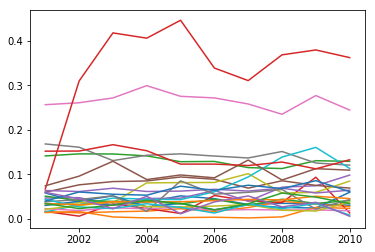

In [2]:
for i in range(25):
    plt.plot(range(2001, 2011), data[i]*100)
plt.show()

# Separate model

In [12]:
sep_models = ["separ_non_unif_prior.stan", "separ_unif_prior.stan", "separ_non_unif_prior_stud.stan"]
sep_stan_models = []
for model in sep_models:
    separate_model_code = open("./models/"+model, "r").read()

    sep_stan_models.append(stan_utility.compile_model_plus(separate_model_code))

Using cached StanModel
Using cached StanModel
Using cached StanModel


In [14]:
N = 10
x = range(2001, 2011)
xpred=2011
K = 25
sep_models_samples = []
for sm in sep_stan_models:
    samples = []
    for i in range(K):
        y = np.log(data[i]).ravel()   # observations
        separate_model_data = dict(
            N = N,
            #K = K,  # 25 contries
            x = x,  # group indicators
            y = y,  # observations
            ymean = y.mean(),
            xpred=xpred
        )

        samples.append(sm.sampling(n_jobs=4, data=separate_model_data))#, control=dict(adapt_delta=0.95, max_treedepth=20)))

        #print('Completed: group ', i)
    print('Completed: separate model')
    sep_models_samples.append(samples)

Completed: separate model
Completed: separate model
Completed: separate model


# Hierarchical

In [4]:
hier_models = ["hier_unif_hyperprior.stan", "hier_non_unif_hyperprior.stan"]
hier_stan_models = []
for model in hier_models:
    model_code = open("./models/"+model, "r").read()
    hier_stan_models.append(stan_utility.compile_model_plus(model_code))
    #hier_stan_models.append(pystan.StanModel(model_code=model_code))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f0a4b0a480636fcaa2be8ca6b94a0f70 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a71a26a3fed49514305a8d6f2b840ec9 NOW.


In [5]:
K=25
nj = 10
N = nj*K
x = np.array([i for i in range(1,K+1) for j in range(10)])
# print(x)
y = np.log(data[0:K]).ravel()  # observations
xpred=K+1

hier_models_samples = []

for sm in hier_stan_models:
    hierarchical_model_data = dict(
        N = N,
        K = K,  # 25 contries
        x = x,  # group indicators
        y = y,  # observations
        xpred=xpred
    )

    hier_models_samples.append(sm.sampling(n_jobs=-1, data=hierarchical_model_data))

print('Completed - hierarchical model')

Completed - hierarchical model


## How Stan model is run

### Separate
Given that we are using a separate model, we created a Stan model which is run once on the data of each country. This gives us K predictions, one for each analysed country.

### Hierarchical
In the hierarchical model we created a single Stan model to analyse the whole dataset at one, considering each parameter `alpha` (respectively `beta`) to be following a common hyperdistribution across all the countries. 

## Convergence analysis
### Separate model

In [15]:
sep_fit = open("sep_model_samples.txt", "w")
sep_divergences = open("sep_model_divergences.txt", "w")
sep_depthtree = open("sep_model_depthtree.txt", "w")
for group in sep_models_samples:
    sep_fit.write("\n\n---------------------------------------------------\n\n")
    sep_divergences.write("\n\n---------------------------------------------------\n\n")
    sep_depthtree.write("\n\n---------------------------------------------------\n\n")
    
    for samples in group:
        sep_fit.write(str(samples))
        sep_divergences.write(str(stan_utility.check_div(samples)))
        sep_depthtree.write(str(stan_utility.check_treedepth(samples)))
sep_fit.close()
sep_divergences.close()
sep_depthtree.close()

[Inference for Stan model: anon_model_ba8aa34327b3630009e75138fd2756da.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       54.96    4.63  49.47 -55.23  24.23  57.93  88.68 147.08    114   1.02
beta        -0.03  2.3e-3   0.02  -0.08  -0.05  -0.03  -0.02   0.02    114   1.02
sigma        0.24  4.8e-3   0.07   0.15   0.19   0.23   0.28   0.42    226   1.01
mu[0]       -7.74    0.01   0.14  -8.04  -7.83  -7.74  -7.65  -7.48    162   1.02
mu[1]       -7.77  8.5e-3   0.12  -8.03  -7.85  -7.77   -7.7  -7.54    194   1.02
mu[2]        -7.8  6.3e-3    0.1  -8.02  -7.87   -7.8  -7.74   -7.6    266   1.01
mu[3]       -7.83  3.6e-3   0.09  -8.02  -7.89  -7.83  -7.78  -7.66    604   1.01
mu[4]       -7.87  1.3e-3   0.08  -8.03  -7.92  -7.87  -7.82   -7.7   3924    1.0
mu[5]        -7.9  1.3e-3   0.08  -8.06  -7.95   -7.9  -7.85  -7.74   39

5.0 of 4000 iterations ended with a divergence (0.125%)
Try running with larger adapt_delta to remove the divergences
2571 of 4000 iterations saturated the maximum tree depth of 10 (64.275%)
Run again with max_depth set to a larger value to avoid saturation
24.0 of 4000 iterations ended with a divergence (0.6%)
Try running with larger adapt_delta to remove the divergences
1765 of 4000 iterations saturated the maximum tree depth of 10 (44.125%)
Run again with max_depth set to a larger value to avoid saturation
9.0 of 4000 iterations ended with a divergence (0.225%)
Try running with larger adapt_delta to remove the divergences
2825 of 4000 iterations saturated the maximum tree depth of 10 (70.625%)
Run again with max_depth set to a larger value to avoid saturation
31.0 of 4000 iterations ended with a divergence (0.775%)
Try running with larger adapt_delta to remove the divergences
2835 of 4000 iterations saturated the maximum tree depth of 10 (70.875%)
Run again with max_depth set to a l

23.0 of 4000 iterations ended with a divergence (0.575%)
Try running with larger adapt_delta to remove the divergences
2794 of 4000 iterations saturated the maximum tree depth of 10 (69.85%)
Run again with max_depth set to a larger value to avoid saturation
189.0 of 4000 iterations ended with a divergence (4.725%)
Try running with larger adapt_delta to remove the divergences
2311 of 4000 iterations saturated the maximum tree depth of 10 (57.775%)
Run again with max_depth set to a larger value to avoid saturation
55.0 of 4000 iterations ended with a divergence (1.375%)
Try running with larger adapt_delta to remove the divergences
2830 of 4000 iterations saturated the maximum tree depth of 10 (70.75%)
Run again with max_depth set to a larger value to avoid saturation
5.0 of 4000 iterations ended with a divergence (0.125%)
Try running with larger adapt_delta to remove the divergences
2896 of 4000 iterations saturated the maximum tree depth of 10 (72.4%)
Run again with max_depth set to a l

7.0 of 4000 iterations ended with a divergence (0.175%)
Try running with larger adapt_delta to remove the divergences
2882 of 4000 iterations saturated the maximum tree depth of 10 (72.05%)
Run again with max_depth set to a larger value to avoid saturation
60.0 of 4000 iterations ended with a divergence (1.5%)
Try running with larger adapt_delta to remove the divergences
1888 of 4000 iterations saturated the maximum tree depth of 10 (47.2%)
Run again with max_depth set to a larger value to avoid saturation
171.0 of 4000 iterations ended with a divergence (4.275%)
Try running with larger adapt_delta to remove the divergences
2380 of 4000 iterations saturated the maximum tree depth of 10 (59.5%)
Run again with max_depth set to a larger value to avoid saturation
31.0 of 4000 iterations ended with a divergence (0.775%)
Try running with larger adapt_delta to remove the divergences
2756 of 4000 iterations saturated the maximum tree depth of 10 (68.9%)
Run again with max_depth set to a larger

For every model separately we have that each value of $\widehat{R}$ is very close to 1.0 and in any case under 1.1, therefore we can say that each model has converged.

### Hierarchical Model

In [6]:
hier_fit = open("hier_model_samples.txt", "w")
hier_divergences = open("hier_model_divergences.txt", "w")
hier_depthtree = open("hier_model_depthtree.txt", "w")
for samples in hier_models_samples:
    hier_fit.write("\n\n---------------------------------------------------\n\n")
    hier_divergences.write("\n\n---------------------------------------------------\n\n")
    hier_depthtree.write("\n\n---------------------------------------------------\n\n")
    hier_fit.write(str(samples))
    hier_divergences.write(str(stan_utility.check_div(samples)))
    hier_depthtree.write(str(stan_utility.check_treedepth(samples)))
hier_fit.close()
hier_divergences.close()
hier_depthtree.close()

37.0 of 4000 iterations ended with a divergence (0.925%)
Try running with larger adapt_delta to remove the divergences
3 of 4000 iterations saturated the maximum tree depth of 10 (0.075%)
Run again with max_depth set to a larger value to avoid saturation
17.0 of 4000 iterations ended with a divergence (0.425%)
Try running with larger adapt_delta to remove the divergences
3 of 4000 iterations saturated the maximum tree depth of 10 (0.075%)
Run again with max_depth set to a larger value to avoid saturation


For the hierarchical model we have that each value for $\widehat{R}$ is very close to 1.0 and in any case under 1.10 . Therefors, we can say that the model is converging.

## Posterior predictive checking

### Separate Model
In order to check how well the different models are fitting the data, we will use leave-one-out (LOO) cross validation method. In particular, we will use PSIS-LOO (Pareto smoothed importance sampling LOO) code for computing approximate LOO-CV. 

Effective number of parameteres:  54.7066132365
PSIS-LOO:  -33.0252425975


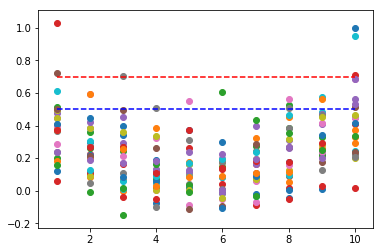

Effective number of parameteres:  61.5172596611
PSIS-LOO:  -33.7766506923


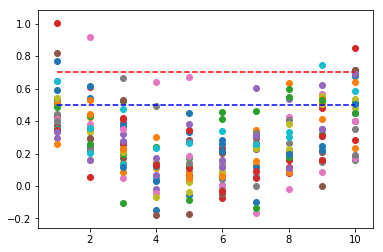

Effective number of parameteres:  53.8420413157
PSIS-LOO:  -31.1019999969


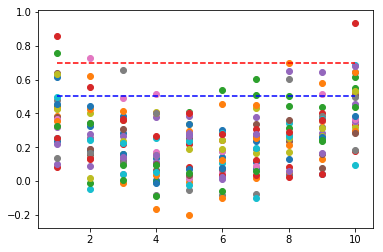

In [17]:
for samples in sep_models_samples:
    S = samples[0]["log_lik"].shape[0]

    log_lik_sep = samples[0]["log_lik"].T
    for sample in samples[1:]:
        log_lik = sample["log_lik"].T
        log_lik_sep = np.concatenate((log_lik_sep,log_lik))
    log_lik_sep = log_lik_sep.T

    loo_sep ,loos_sep, ks_sep = psis.psisloo(log_lik_sep)
    lppd_sep = np.sum(np.log(np.mean(np.exp(log_lik_sep), axis = 0)))
    p_eff_sep = lppd_sep - loo_sep
    print("Effective number of parameteres: ", p_eff_sep)
    print("PSIS-LOO: ", loo_sep)

    K_plot = 25
    ks_sep_matrix = ks_sep.reshape((K_plot,10))
    '''
    for i, sample in enumerate(samples):
        log_lik_i = sample["log_lik"]
        loo_sep_i ,loos_sep_i, ks_sep_i = psis.psisloo(log_lik_i)
        lppd_sep_i = np.sum(np.log(np.mean(np.exp(log_lik_i), axis = 0)))
        p_eff_sep_i = lppd_sep_i - loo_sep_i
        print("-------------------------------------")
        print("Group ", i)
        print("K values > 0.7: {}".format(np.sum(ks_sep_i>=0.7)))
        print("K values > 0.5: {}".format(np.sum(ks_sep_i>0.5)))
        #print("Agg K values > 0.7: {}".format(np.sum(ks_sep_matrix[i]>=0.7)))
        #print("Agg K values > 0.5: {}".format(np.sum(ks_sep_matrix[i]>0.5)))
        print("p_eff for group ", i, ": ", p_eff_sep_i)
        print("p_eff avg: ", p_eff_sep/25)
    '''

    for i in range(K_plot):
        plt.scatter(range(1,11), ks_sep_matrix[i])
    plt.plot(range(1,11), [0.5 for i in range(1,11)], "b--")
    plt.plot(range(1,11), [0.7 for i in range(1,11)], "r--")
    plt.show()


The results show that the number of effective estimated parameters for the model of each country is close to 3 for most of them, with some exceptions going as low as 2 and as high as 4. On average the number of effective estimated parameters approaces 3 as well. That is what we expected, since each model depends on three parameters: $\alpha$, $\beta$ and $\sigma$.

Accordingly, most of the models had appropriate k values. Anyway, in some of them we have that some values are over 0.5 and so in these cases the $p_{eff}$ values are biased.

### Hierarchical Model

Effective number of parameteres:  44.5817042779
PSIS-LOO:  -58.7745469836


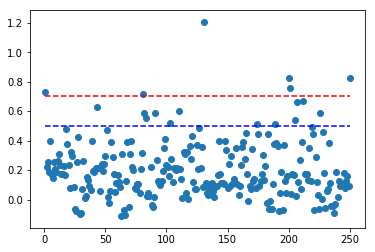

Effective number of parameteres:  44.1442095546
PSIS-LOO:  -58.3380553907


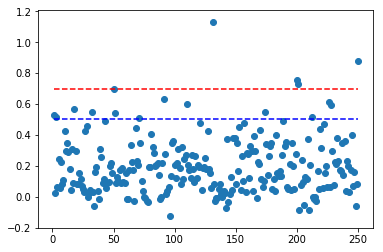

In [7]:
for samples in hier_models_samples:
    log_lik_hier = samples["log_lik"]

    loo_hier ,loos_hier, ks_hier = psis.psisloo(log_lik_hier)
    lppd_hier = np.sum(np.log(np.mean(np.exp(log_lik_hier), axis = 0)))
    p_eff_hier = lppd_hier - loo_hier
    print("Effective number of parameteres: ", p_eff_hier)
    print("PSIS-LOO: ", loo_hier)

    plt.scatter(range(1,251), ks_hier)
    plt.plot(range(1,251), [0.5 for i in range(1,251)], "b--")
    plt.plot(range(1,251), [0.7 for i in range(1,251)], "r--")
    plt.show()

## Model Comparison

We want now to compare the predictive performance of the two models that we used in the previous sections.
In order to do so we will use the produced PSIS-LOO values for both models:

## Prediction for the next year
### Separate model

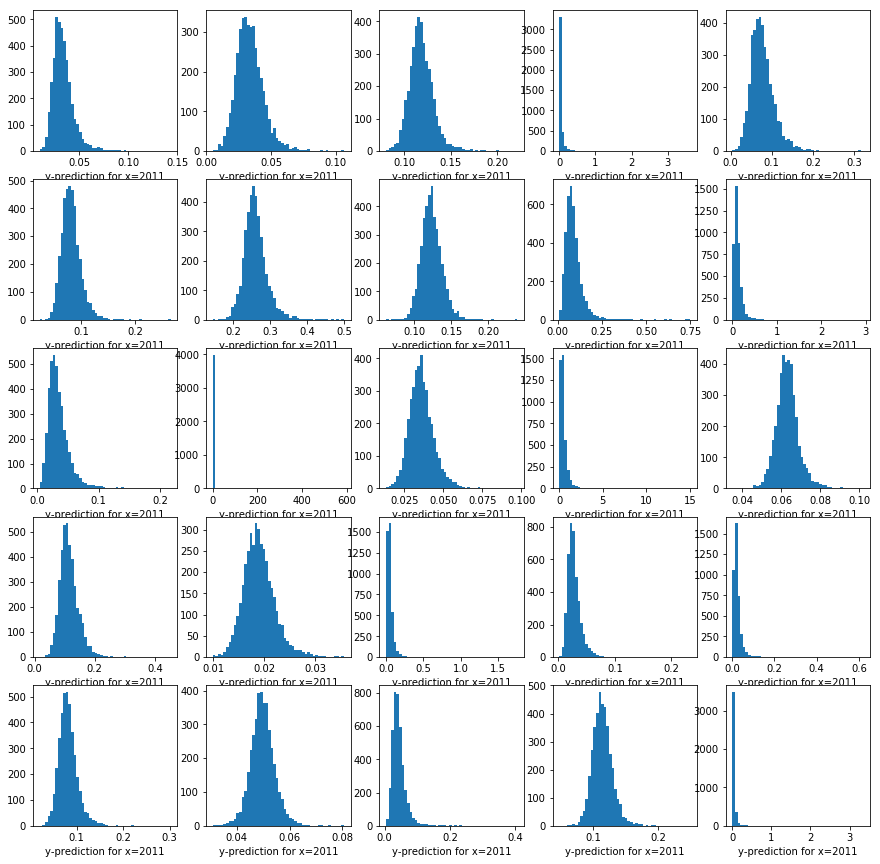

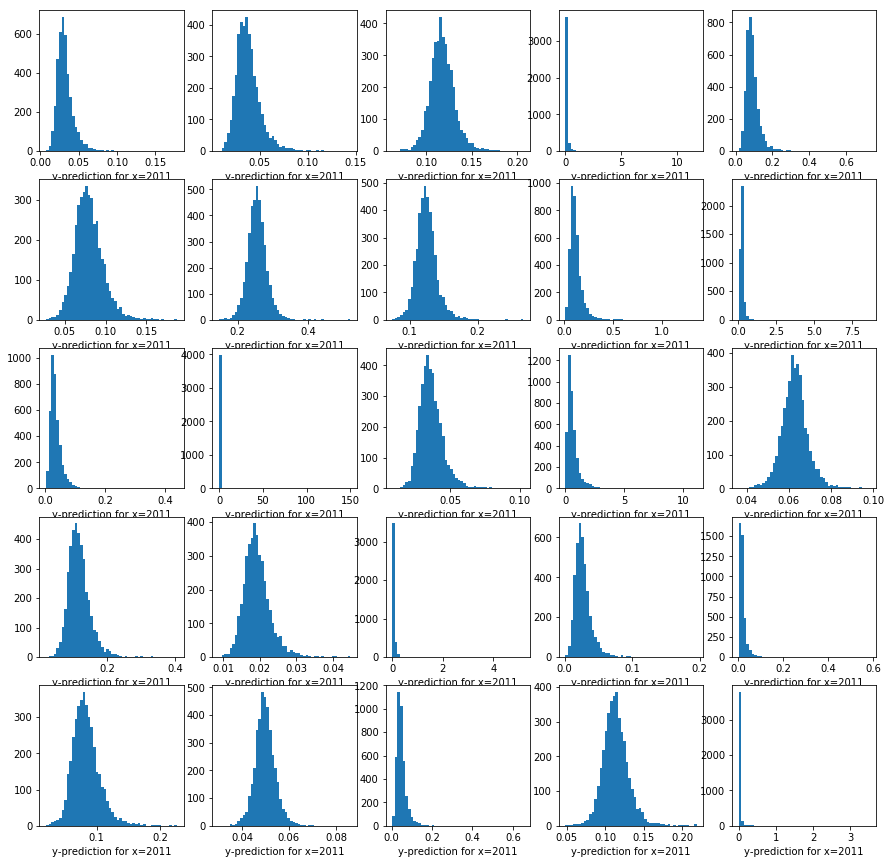

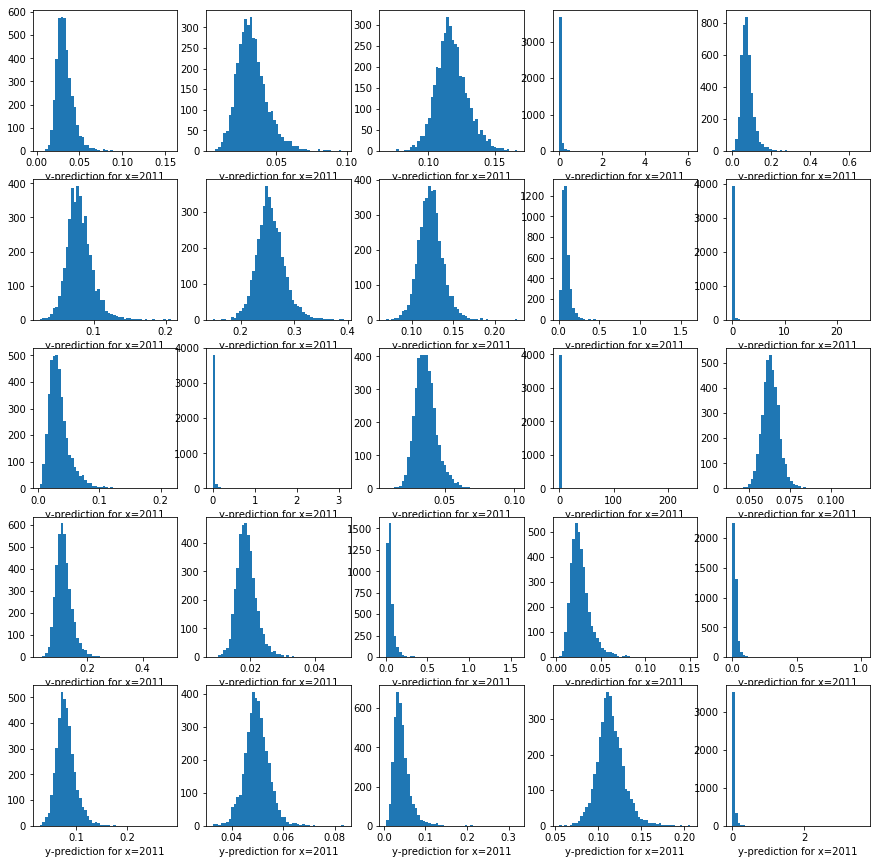

In [18]:
for model in sep_models_samples:
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    for i, samples in enumerate(model):
        ax = axes[int(i/5), i%5]
        ax.hist(np.exp(samples['ypred'])*100, 50)
        ax.set_xlabel('y-prediction for x={}'.format(2011))
        
    plt.show()

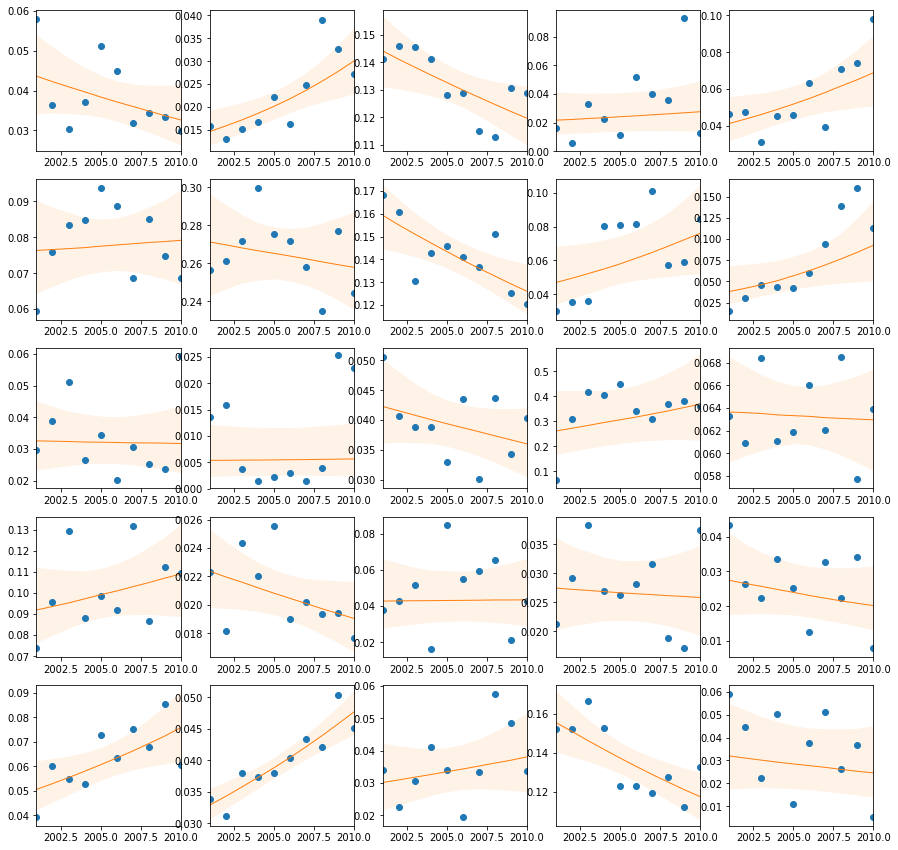

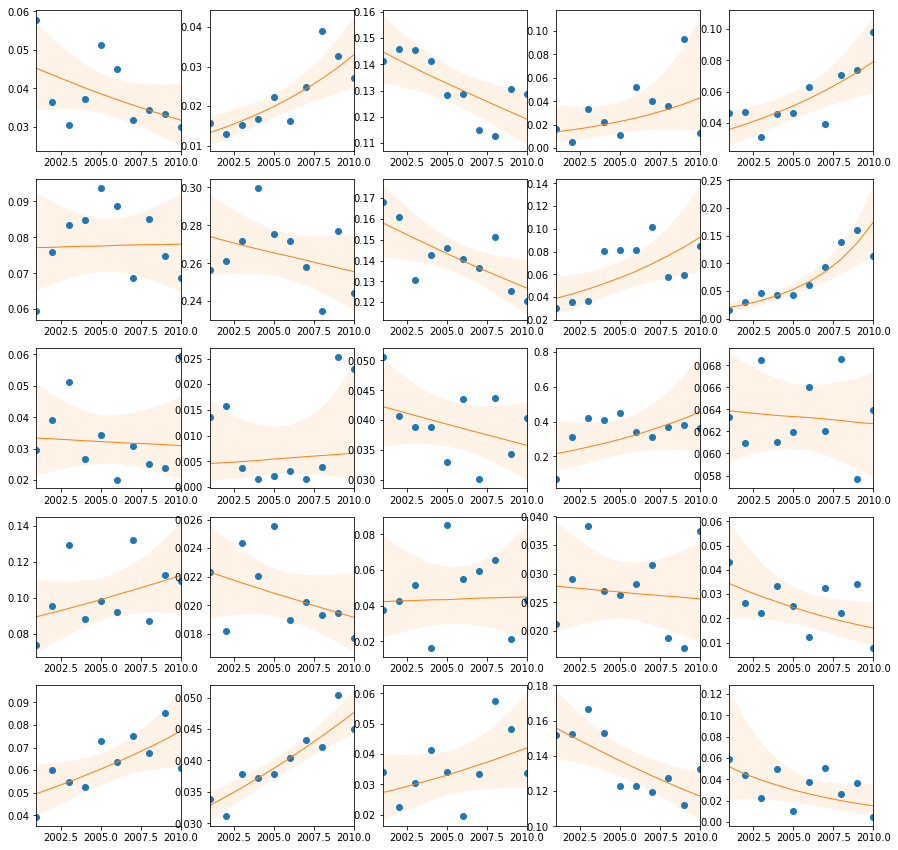

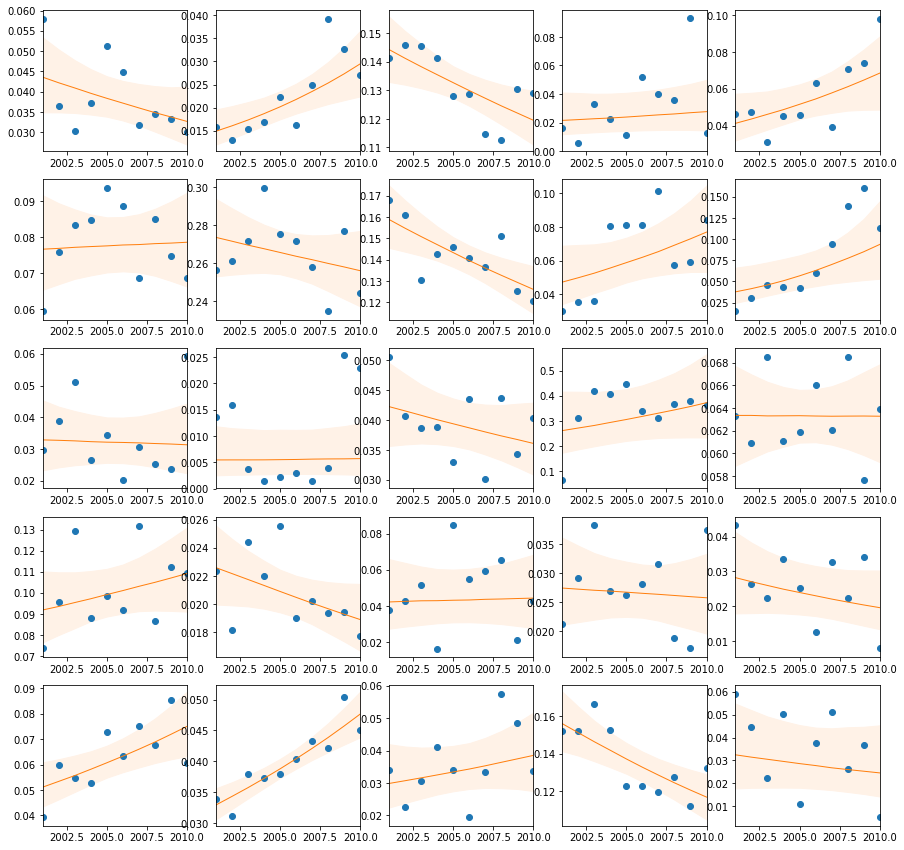

In [19]:
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C1'     # 'C1' for default color #1
for model in sep_models_samples:
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    for i, samples in enumerate(model):
        ax = axes[int(i/5), i%5]
        #ax.hist(np.exp(samples['ypred']), 50)
        #ax.set_xlabel('y-prediction for x={}'.format(2011))        
        
        color_shade = (
            1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
        )

        expmu = np.exp(samples['mu'])*100
        
        ax.fill_between(
            range(2001,2011),
            np.percentile(expmu, 5, axis=0),
            np.percentile(expmu, 95, axis=0),
            color=color_shade
        )

        ax.plot(
            range(2001,2011),
            np.percentile(expmu, 50, axis=0),
            color=color_line,
            linewidth=1
        )

        ax.scatter(range(2001,2011), data[i]*100) #5, color=color_scatter)
        ax.set_xlim((2001, 2010))
        
        #ax.tight_layout()
    plt.show()

### Hierarchical model

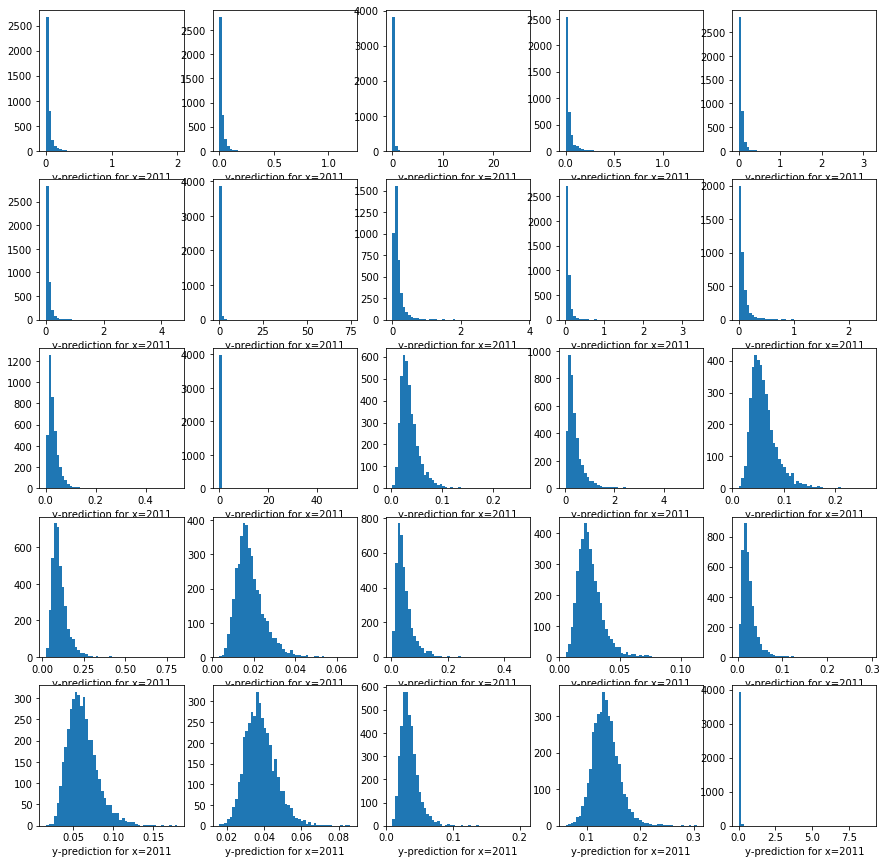

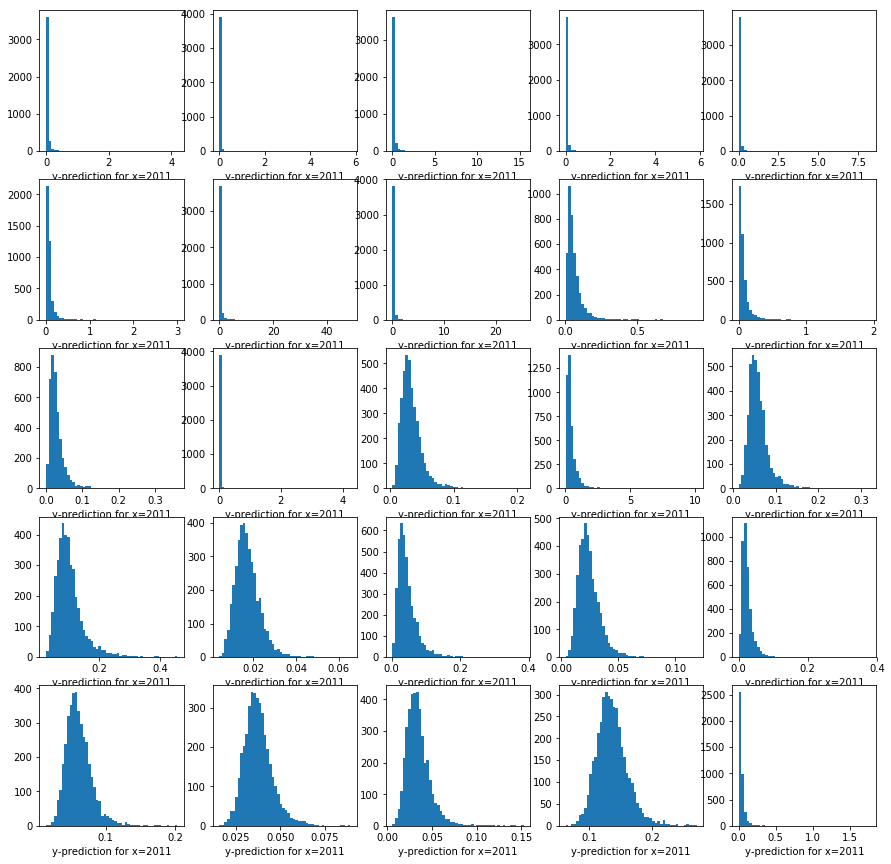

In [8]:
for samples in hier_models_samples:
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    for i in range(samples['ypred'].shape[1]):
        ax = axes[int(i/5), i%5]
        ax.hist(np.exp(samples['ypred'][:, i])*100, 50)
        ax.set_xlabel('y-prediction for x={}'.format(2011))
        
    plt.show()

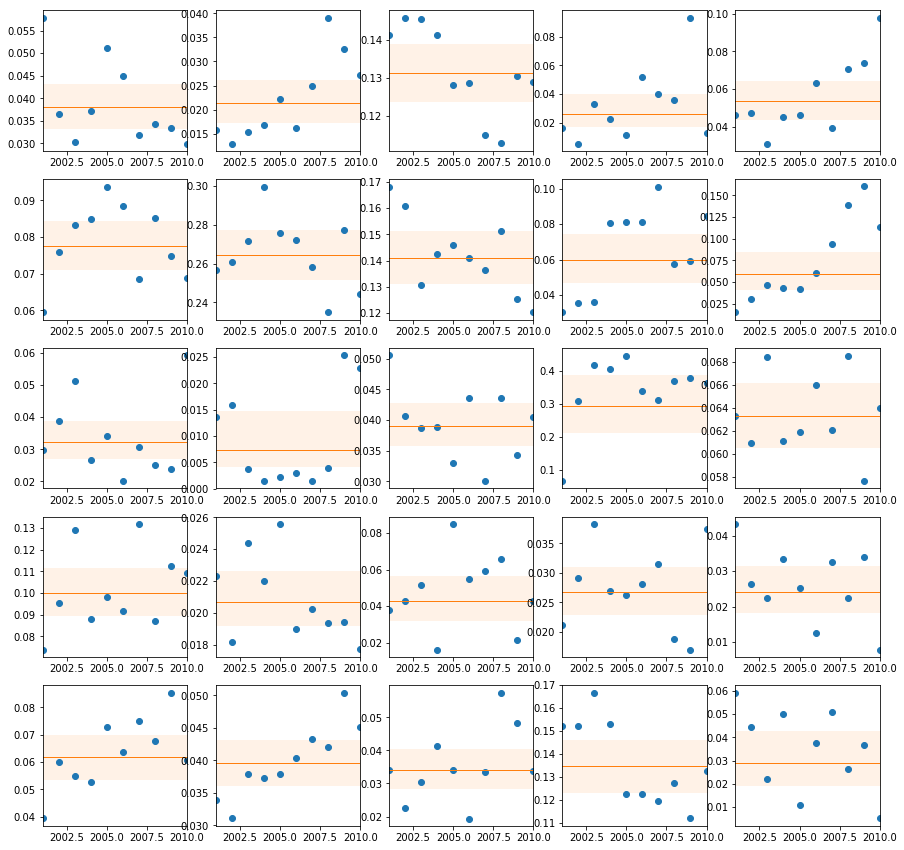

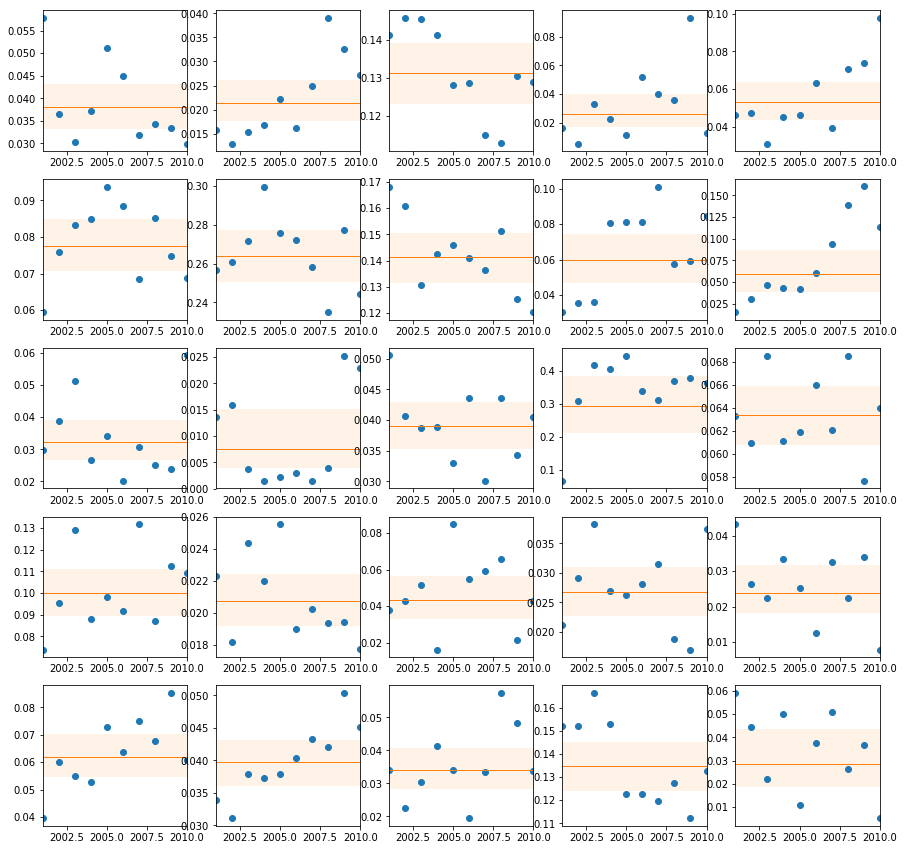

In [9]:
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C1'     # 'C1' for default color #1
for samples in hier_models_samples:
#     print(samples['mu'].shape)
    
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    for i in range(samples['ypred'].shape[1]):
        ax = axes[int(i/5), i%5]
        #ax.hist(np.exp(samples['ypred']), 50)
        #ax.set_xlabel('y-prediction for x={}'.format(2011))        
        #print(samples['mu'][:, 10*i:10*(i+1)])
        color_shade = (
            1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
        )

        expmu = np.exp(samples['mu'][:, 10*i:10*(i+1)])*100
        
        ax.fill_between(
            range(2001,2011),
            np.percentile(expmu, 5, axis=0),
            np.percentile(expmu, 95, axis=0),
            color=color_shade
        )

        ax.plot(
            range(2001,2011),
            np.percentile(expmu, 50, axis=0),
            color=color_line,
            linewidth=1
        )

        ax.scatter(range(2001,2011), data[i]*100) #5, color=color_scatter)
        ax.set_xlim((2001, 2010))
        
        #ax.tight_layout()
    plt.show()
    

## Predictive performance assessment

Total MSE:  0.0138730183009


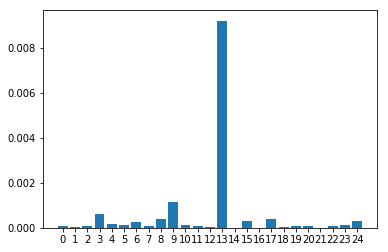

Total MSE:  0.0146090860974


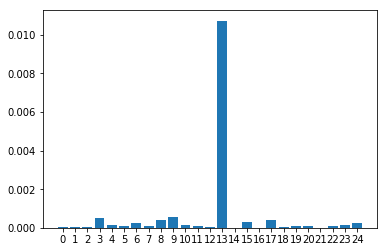

Total MSE:  0.0138682944103


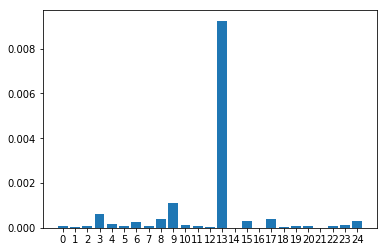

In [36]:
mse_models = []
for model in sep_models_samples:
    mse_list = []
    for i, samples in enumerate(model):
        expmu = np.exp(samples['mu'])*100        
        pred = np.percentile(expmu, 50, axis=0)
        
        mse = mean_squared_error(data[i]*100, pred)
        mse_list.append(mse)
    mse_models.append(mse_list)
for mse_lst in mse_models:
    print("Total MSE: ", np.sum(mse_lst))
    plt.bar(range(25), mse_lst)
    plt.xticks(range(25))
    plt.show()

 - confrontare i modelli sulla base di psis-loo
 Non possiamo confrontare i vari modelli separati perchè i k value ci dicono che i valori di PSIS-loo non sono abbastanza reliable ma possiamo dire che, dato che la differenza con quelli dei modelli gerarchici è alta, è probabile che le performance dei  modelli gr
 - 